# This is an attempt to learn by building and training an LLM from Scratch  

In [1]:
import os
from pathlib import Path

import torch
from torch import Tensor
import urllib.request
    
    

# Check which GPU if any is available
# torch.cuda.is_available():
#     device = torch.device("cuda")
#     x: Tensor = torch.ones(1, device=device)
#     print(f"x = {x} using 'cuda:0' backend")
#     
# elif 
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x: Tensor = torch.ones(1, device=device)
    print(f"x = {x} using {device} backend")
else:
    device = torch.device("cpu")
    # x: Tensor = torch.ones(1, device=device)
 
print(device)

def get_some_text():
    # Now lets load the text data
    bookUrl = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"  # Download a text (book)
    filepath = "../data/the-verdict.txt"
    # print(file_path)
    
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(bookUrl, filepath)

    with open(filepath, "r", encoding="utf-8") as f:
        rawtext = f.read()
        
    print("Total characters in the story: ", len(rawtext))
    print("Total Lines in raw text: ", rawtext.count("\n"))
    return rawtext

raw_text = get_some_text()
print("Some text: ", raw_text[:49])

x = tensor([1.], device='mps:0') using mps backend
mps
Total characters in the story:  20479
Total Lines in raw text:  164
Some text:  I HAD always thought Jack Gisburn rather a cheap 


In [2]:
# Now we have to tokenize the text. The best way to do that is to use a pre-build tokennizer, but first we will try some 
# basic python regular expressions to do the same things
import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
#
print(len(preprocessed))
print(preprocessed[:30])

4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [3]:
# Now we need to generate token IDs
# Now let us create a list of all unique tokens and sort them alphabetically to determine the vocabulary size
all_uniq_words = sorted(set(preprocessed))
vocab_size = len(all_uniq_words)
print("Vocab size: ", vocab_size)

# Now that we know the vocabulary size, lets enumerate and assign some numbers to them
vocab = {token:integer for integer,token in enumerate(all_uniq_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 20:
        break


Vocab size:  1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


In [4]:
from src.chapter02.SimpleTokenizerV1 import SimpleTokenizerV1

# Now we want to apply this vocabulary to convert new text to generate token id
# When we want to convert the outputs of an LLM from numbers back into text, we need a way to turn token IDs into text. 
# For this, we can create an inverse version of the vocabulary that maps token IDs back to the corresponding text tokens.

tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted you know," 
        Mrs Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 1126, 596, 5, 1, 67, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted you know," Mrs Gisburn said with pardonable pride.


In [5]:
all_tokens = sorted(list(set(preprocessed))) # Make preprocessed a list so we can extend it
all_tokens.extend(["<|unk|>", "<|endoftext|>"])
# redo the vocab population
vocab = {token:integer for integer, token in enumerate(all_tokens)}
print(len(vocab.items()))


1132


In [6]:
# Print the last 5 vocab items
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|unk|>', 1130)
('<|endoftext|>', 1131)


In [7]:
from src.chapter02.SimpleTokenizerV2 import SimpleTokenizerV2

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1130, 5, 355, 1126, 628, 975, 10, 1131, 55, 988, 956, 984, 722, 988, 1130, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [8]:
### Byte Pair Encoding 
from importlib.metadata import version
import tiktoken
print("Tiktoken version: ", version("tiktoken"))
#print("Tiktoken version: ", tiktoken.__version__)

Tiktoken version:  0.8.0


In [9]:
#### This is the tokenizer using the GPT2 tokenization model
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(f"Encoded: {integers}")
strings = tokenizer.decode(integers)
print(f"Decoded: {strings}")

Encoded: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Decoded: Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [10]:
print(tokenizer.encode("Akwirw ier"))
print(tokenizer.decode(tokenizer.encode("Akwirw ier")))

[33901, 86, 343, 86, 220, 959]
Akwirw ier


In [11]:
# Let's now do Data Sampling with a sliding window
# 1. Let's tokenize the entire story with BPE tokenizer first

encoded_text = tokenizer.encode(raw_text)
print(len(encoded_text))
enc_sample = encoded_text[50:]

# Now Let's start by defining x and y where x has input tokens and y the output tokens shifted by 1
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
# print(f"x: {x}")
# print(f"y:      {y}")


#####
# Next word prediction tasks can now be created by 
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    # print(f"context input: {context} --> desired prediction: {desired}")
    # Now we create the input output target pairs
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

5145
 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [12]:
# from Dataloader import Dataloader
# 
# dataloader = Dataloader(batch_size=8, max_length=4, stride=4, shuffle=False, drop_last=True, num_workers=0)
# dataloader = dataloader.get_instance(file_path, text_enc='utf-8', mode='r')
# if dataloader is not None:
#     data_iter = iter(dataloader)
#     inputs, targets = next(data_iter)
#     print("Loaded text data...\n")
#     print("Inputs: \n", inputs)
#     print("\nTargets: \n", targets)
# else: 
#     print("Failed loading ", dataloader)


In [13]:
import torch.nn
from src.chapter02.Dataloader import Dataloader
from src.chapter02.GPTDatasetV1 import GPTDatasetV1
file_path = "../data/the-verdict.txt"

####
# Finally we need to create the embeddings for the tokens
# If we have a batch size of 8 with 4 tokens each it'll be an 8 x 4 x 256 tensor
max_length = 4  
max_length = 4  

mydataloader = Dataloader(batch_size=8, max_length=max_length, stride=4, shuffle=False, drop_last=True, num_workers=0)
dataloader = mydataloader.create_dataloader_v1(txt=raw_text)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
# print("Input Token IDs:\n", inputs)
# print("Input tensor shape: ", inputs.shape) 

# Now since self-attentions are position agnostic, we should add some positional data.
# Absolute and relative positional data can be added. So let's create embeddings with say 256 dimensions
vocab_size = 50257
output_dim = 256
# context_length = 1024

## Now lets embed the input tensors
token_embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=output_dim)
token_embeddings = token_embedding_layer(inputs)
print("Token embeddings shape: ", token_embeddings.shape) #8x4x256


# For a GPT model’s absolute position embedding approach, we just need to create another embedding 
# layer that has the same embedding dimension as the token_embedding_ layer:
context_length = max_length     #context is length of positions we care about for attention
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print("Positional Embeddings Shape: ", pos_embeddings.shape) # 4x256
#
# Add the positional embeddings to token embeddings
input_embeddings = token_embeddings + pos_embeddings
print("Position Merged Input Embeddings Shape: ", input_embeddings.shape)
#
# Now lets look at the dataloader
for batch in dataloader:
    inputs, targets = batch
    token_embeddings = token_embedding_layer(inputs)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))
    input_embeddings = token_embeddings + pos_embeddings
    break
#
print("Batch Embeddings Shape: ", input_embeddings.shape)
    
print("Input tensor ", x)
print("Target tensor", y)

Token embeddings shape:  torch.Size([8, 4, 256])
Positional Embeddings Shape:  torch.Size([4, 256])
Position Merged Input Embeddings Shape:  torch.Size([8, 4, 256])
Batch Embeddings Shape:  torch.Size([8, 4, 256])
Input tensor  [290, 4920, 2241, 287]
Target tensor [4920, 2241, 287, 257]


In [14]:
# Chapter 3 - Attention
#
import torch

# In self-attention our goal is to calculate context vector z(i) for each 
# element x(i) of the input sequence. Consider the following input sequence 
#
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
# inputs.to(device)
print("Input sequence shape: ", inputs.shape)
# 
# Now calculate weights for attention
# Assume query is the second word "journey" or inputs[1] 
#
query = inputs[1]
# query.to(device)
print(f"Query is the 2nd word 'journey': {query}")
#
attention_scores_2 = torch.empty(inputs.shape[0])
# attention_scores_2.to(device)
for idx, x_i in enumerate(inputs):
    attention_scores_2[idx] = torch.dot(x_i, query)
#    print(f"Sequence Element [{idx}], attention_score: {attention_scores_2}")
print(f"Final value of attention_score_2: {attention_scores_2}")


Input sequence shape:  torch.Size([6, 3])
Query is the 2nd word 'journey': tensor([0.5500, 0.8700, 0.6600])
Final value of attention_score_2: tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [15]:

## Note: For all elements if we were to calculate attention it'd be a O(n^2) operation
# NOW we normalize the attention weights, so they sum up to 1
attention_weights_2_tmp = attention_scores_2 / attention_scores_2.sum()
# attention_weights_2_tmp.to(device)
print("Normalized attention weights:", attention_weights_2_tmp)
print("Sum of attention weights:", attention_weights_2_tmp.sum())

## Generally we normalize using the softmax to do the normalization

# # define a softmax function
def softmax_naive(tensor_x):
    return torch.exp(tensor_x) / torch.exp(tensor_x).sum(dim=0, keepdim=True)
# 

attention_scores_2_naive = softmax_naive(attention_scores_2)
# attention_scores_2_naive.to(device)

print("Attention weights naive:", attention_scores_2_naive)
print ("Naive Sum: ", attention_scores_2_naive.sum())
# 
# Generally we normalize using the torch.softmax() to do the normalization
# Softmax ensures its always positive and always adds up to 1
#
attention_weights_2_torch_softmax = torch.softmax(attention_scores_2, dim=0)
# attention_weights_2_torch_softmax.to(device)
print("Attention weights torch softmax:", attention_weights_2_torch_softmax)
# print("Attention weights torch softmax Sum: ", attention_weights_2_torch_softmax.sum())

# Now that we have calculated the normalized attention weights, we are ready for the final step.
# Calculate the context vector z(2) by multiplying the embedded input tokens x(i), 
# with the corresponding normalized attention weights and then summing the resultant vectors
#
query = inputs[1]
# query.to(device)
#
context_vec_2 = torch.zeros(query.shape)
# context_vec_2.to(device)
#
for i, x_i in enumerate(inputs):
    context_vec_2 += (attention_weights_2_torch_softmax[i] * x_i)
print("Context vector z2: ", context_vec_2)

#
# Now in similar fashion lets calculate attention scores for all the input sequences 
attention_scores = torch.empty(inputs.shape[0],inputs.shape[0])
# attention_scores.to(device)
print("\nAttention Scores matrix shape: ", attention_scores.shape)
#
# Using for loops
#
# for i, x_i in enumerate(inputs):
#     for j, x_j in enumerate(inputs):
#         attention_scores[i, j] = torch.dot(x_i, x_j)
# #
#print(attention_scores)
#
# Using matrix multiplication we can do it faster
#
attention_scores_m = inputs @ inputs.T
# attention_scores_m.to(device)
#print("Normalized attention scores \n", attention_scores_m)

# Just as before lets normalize the rows, so they sum up to 1
# NOTE: Here dim = -1 means we are applying the softmax along the last dimension of the attention_scores_m tensor
#
attention_weights = torch.softmax(attention_scores_m, dim=-1)
# attention_weights.to(device)
#print("Normalized ATTENTION weights \n", attention_weights)
# print("Softmax Sums:\n", attention_weights.sum(dim=-1))

# FINAL STEP
# Now let's calculate the context vectors for all the input by multiplying the input with attention weights
all_context_vectors = attention_weights @ inputs # Matrix multiplication
# all_context_vectors.to(device)
#print("Context vector for the entire sequence\n", all_context_vectors)

Normalized attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum of attention weights: tensor(1.0000)
Attention weights naive: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Naive Sum:  tensor(1.)
Attention weights torch softmax: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Context vector z2:  tensor([0.4419, 0.6515, 0.5683])

Attention Scores matrix shape:  torch.Size([6, 6])


In [16]:

###
### 3.4.1 Using weighted matrix
###
#
# Computing the attention weights step by step
#
torch.manual_seed(123)
x_2 = inputs[1]
# x_2.to(device)
d_in = inputs.shape[1]
d_out = 2
print("x_2: ", x_2)
# Now let's initialize 3 weighted matrices Wq, Wk and Wv
# Setting requires_grad = False, to reduce clutter, but for model training this should be set to True

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
#
# Next we compute the query, key and value vectors
# Note the output is a 2 dimenstional vector because we set dout to 2
#
# W_query.to(device)
# W_key.to(device)
# W_value.to(device)
#
# Now the dot product with the input
#
query_2 = x_2 @ W_query
key_2   = x_2 @ W_key
value_2 = x_2 @ W_value
#
# query_2.to(device)
# key_2.to(device)
# value_2.to(device)
#
print("Query 2: ", query_2)
print("Key 2:   ", key_2)
print("Value 2: ", value_2)
#
print("\n")
#

keys = inputs @ W_key 
values = inputs @ W_value
# keys.to(device)
# values.to(device)
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys_2 = keys[1]

attn_score_22 = query_2.dot(keys_2)
# attn_score_22.to(device)
# attn_score_22 = query_2 @ keys_2
print("Attention (dot) score 22:", attn_score_22)

# Generalizing across all inputs
attn_scores_2 = query_2 @ keys.T
# attn_scores_2.to(device)
print("Attention \\@ Scores 2: ", attn_scores_2)
# Check the second element is same as previously calculated attention score
#
# We compute the attention weights by scaling the attention scores and using the softmax function. 
# However, now we scale the attention scores by dividing them by the square root of the embedding 
# dimension of the keys

attn_weights_2 = torch.softmax(attn_scores_2 / keys.shape[-1]**0.5, dim=-1)
# attn_weights_2.to(device)
print("attn_weights_2: ", attn_weights_2)

# The reason for the normalization by square root of embedding dimension size is to improve the training performance by avoiding small gradients. 
# For instance, when scaling up the embedding dimension, which is typically > 1,000 for GPT-like LLMs, large dot products can result in 
# very small gradients during backpropagation (due to the softmax function applied to them). 
# As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. 
# These small gradients can drastically slow down learning or cause training to stagnate.
#
# The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.
# Similar to when we computed the context vector as a weighted sum over the input vectors 
# we now compute the context vector as a weighted sum over the value vectors. 
# Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector
context_vec_2 = attn_weights_2 @ values
# context_vec_2.to(device)
print("context_vec_2: ", context_vec_2)


x_2:  tensor([0.5500, 0.8700, 0.6600])
Query 2:  tensor([0.4306, 1.4551])
Key 2:    tensor([0.4433, 1.1419])
Value 2:  tensor([0.3951, 1.0037])


keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
Attention (dot) score 22: tensor(1.8524)
Attention \@ Scores 2:  tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
attn_weights_2:  tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
context_vec_2:  tensor([0.3061, 0.8210])


In [17]:
from src.chapter03.SelfAttention_v2 import SelfAttention_v2

torch.manual_seed(789)
self_attn_v2 = SelfAttention_v2(d_in, d_out)
#print("Context vectors from SelfAtten_v2: \n", self_attn_v2(inputs))

# Note since the input contains 6 embedding vectors, the output also has 6 rows of context vectors


# Causal Attention 
# First we apply softmax to the attention scores then mask with 0 above the diagonal and then normalize the rows to 1
#
queries = self_attn_v2.W_query(inputs)
# queries.to(device)

keys = self_attn_v2.W_key(inputs)
# keys.to(device)

attn_scores = queries @ keys.T
# attn_scores.to(device)

attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
# attn_weights.to(device)
#print("Attention Wrights: \n",attn_weights)

# Now mask the values above diagonal as 0 using the tril() function
#
context_length = attn_scores.shape[0]
#
mask_simple = torch.tril(torch.ones(context_length, context_length))
#print("Mask Simple: \n", mask_simple)
#
# Now simply multiply them to prevent the look ahead 
#
masked_attention_weights = attn_weights * mask_simple
# masked_attention_weights.to(device)
#print("Masked attention weights: \n", masked_attention_weights)

#
# Now re-normalize to make sure rows add up to 1. To do this we divide each element by sum of each row
#
row_sums = masked_attention_weights.sum(dim=-1, keepdim=True)
#print("row_sums: \n", row_sums)
masked_simple_norm = masked_attention_weights / row_sums
print("Masked & re-normalized weights: \n", masked_simple_norm)

x = tensor([1.], device='mps:0') using 'mps:0' backend
Masked & re-normalized weights: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [18]:
# A more efficient way to obtain masked attention weights is to mask the attention scores with 
# negative infinity before applying softmax function. (e^negative infinity -> 0)
# We can implement this masking by replacing values above the diagonal with 1 and then replacing them 
# with negative infinity
#
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
# mask.to(device)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
# masked.to(device)
print("Masked attention weights: \n", masked)
#
# Now apply the softmax function 
#
attn_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim=-1)
print("Softmax'd Attention weights: \n", attn_weights)

# Now we can use these modified attention weights to calculate the context vector
#
context_vec = attn_weights @ values
print("context_vec: \n", context_vec)

Masked attention weights: 
 tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)
Softmax'd Attention weights: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)
context_vec: 
 tensor([[0.1855, 0.8812],
        [0.2795, 0.9361],
        [0.3133, 0.9508],
        [0.2994, 0.8595],
        [0.2702, 0.7554],
        [0.2772, 0.7618]]

In [19]:
# Masking additional weights with dropout
# Drop out in the attention mechanism is applied at 2 specific times: 
# 1. After calculating the attention weights
# 2. After applying the attention weights to value vectors
# Here we will apply the dropout mask after computing the attention weights
#
# Lets use a dropout rate of 50% meaning half the attention weights will be masked out. 
# Normally it's a much lower rate like 0.1 or 0.2
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))
#
# Since we are applying 50% dropout, to compensate for reduction in active elements
# we are going to scale up the values of remaining elements by a factor of 1/0.5 = 2
# This scaling is crucial to maintain the balance of the attention weights
#
torch.manual_seed(123)
print("Dropped out attention weights: \n", dropout(attn_weights))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])
Dropped out attention weights: 
 tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


In [20]:
from src.chapter03.CausalAttention import CausalAttention

# Let’s ensure that the code can handle batches consisting of more than one input so that 
# the CausalAttention class supports the batch outputs produced by the data loader
# To simulate batch input lets duplicate the input text
#
batch = torch.stack((inputs, inputs), dim=0)
# batch.to(device)
print("batch: \n", batch.shape)
# print(batch)
#
# We can now use the CausalAttention class as follows
#
torch.manual_seed(123)
context_layer = batch.shape[1]
causal_attn = CausalAttention(d_in, d_out, context_length, 0.0, False)
context_vecs = causal_attn(batch)
print("context_vecs: \n", context_vecs.shape)

batch: 
 torch.Size([2, 6, 3])
context_vecs: 
 torch.Size([2, 6, 2])


In [21]:
from src.chapter03.MultiHeadAttentionWrapper import MultiHeadAttentionWrapper

# Multi Head Attention
# Now if we use the MultiHeadAttentionWrapper class with two attention heads, and CausalAttention 
# output dimension d_out = 2, we get a 4 dimensional context vector (d_out * num_heads = 4).
#
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
multi_head_attn = MultiHeadAttentionWrapper(d_in, d_out, context_length, dropout=0.0, num_heads=2, qkv_bias=False)
context_vecs = multi_head_attn(batch)
print("context_vecs: \n", context_vecs)
print("context_vecs.shape: \n", context_vecs.shape)


context_vecs: 
 tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: 
 torch.Size([2, 6, 4])


In [22]:
# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device('mps')
#     x = torch.ones(1, device=mps_device)
#     print(x)
# else:
#     print("mps not available")

In [23]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])
# print(a.transpose(2, 3))
# a.to(device)

first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

print(f"Batched: \n{a @ a.transpose(2, 3)}")

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])
Batched: 
tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [24]:
from src.chapter03.MultiHeadAttention import MultiHeadAttention

torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
print("Batch Shape: \n", batch.shape)
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("Context vector shape: \n", context_vecs.shape)


Batch Shape: 
 torch.Size([2, 6, 3])
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
Context vector shape: 
 torch.Size([2, 6, 2])



---
## Chapter 4: Implementing GPT from Scratch to generate text

---

In [25]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False,
    "model_name": "GPTModel",
    "lr": 5e-4,
    "weight_decay": 0.1
}

## Here is the proposed architecture and order of implementation
![image](../data/4-3.png)


In [26]:
from src.chapter04.DummyGPTModel import DummyGPTModel
import tiktoken
#
torch.manual_seed(123)
#
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.clear()
batch.append(torch.tensor(tokenizer.encode(txt1)).to(device))
batch.append(torch.tensor(tokenizer.encode(txt2)).to(device))
batch = torch.stack(batch, dim=0).to(device)
batch.to(device)
print("Input Batch: \n", batch)
print("Input batch shape: \n", batch.shape)
#
# Next, we initialize a new 124-million-parameter DummyGPTModel instance 
# and feed it the tokenized batch
#
model = DummyGPTModel(GPT_CONFIG_124M)
model.to(device)
logits = model(batch)
print("Output shape: \n", logits.shape)
#print(logits)
#                      
#

Input Batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]], device='mps:0')
Input batch shape: 
 torch.Size([2, 4])
Output shape: 
 torch.Size([2, 4, 50257])


In [27]:
import torch
from torch import nn

# Let’s now implement LAYER Normalization to improve the stability and efficiency of the training.
# The main idea behind LAYER Normalization is to adjust the activations (outputs) of a deep
# neural network layer to have a mean of 0 and a variance of 1
#
# This adjustment speeds up the convergence.
#
torch.manual_seed(123)
torch.set_printoptions(sci_mode=False)
#
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print("Layer: \n",out)
#
# The NN Layer contains the non-linear activation ReLU which 0's out the negative values
# 
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: ", mean)
print("Variance: ", var)
print("\n")
#
# Next, let’s apply layer normalization to the layer outputs we obtained earlier. 
# The operation consists of subtracting the mean and dividing by the square root 
# of the variance (also known as the standard deviation):
#
eps = 1e-5
out_norm = (out - mean) / torch.sqrt(var)
# Dim = -1 indicates statistics along the last dimention
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=True)
print("Normalized Layer Outputs: \n", out_norm)
print("Mean: \n", mean)
print("Variance: \n", var)
print("-------------------------\n")

torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)


Layer: 
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Normalized Layer Outputs: 
 tensor([[6.1585e-01, 1.4126e+00, -8.7188e-01, 5.8723e-01, -8.7188e-01, -8.7188e-01],
        [-1.8865e-02, 1.1211e-01, -1.0876e+00, 1.5173e+00, 5.6474e-01, -1.0876e+00]],
       grad_fn=<DivBackward0>)
Mean: 
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000e+00],
        [1.0000e+00]], grad_fn=<VarBackward0>)
-------------------------

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [28]:
from src.chapter04.LayerNorm import LayerNorm

# Previously we used unbiased = False in our variance calculation. This doesn't 
# apply Bessel's correction where divisor is n-1 instead of n. But this is 
# compatible with GPT-2

ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean: \n", mean)
print("Variance: \n", var)


Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


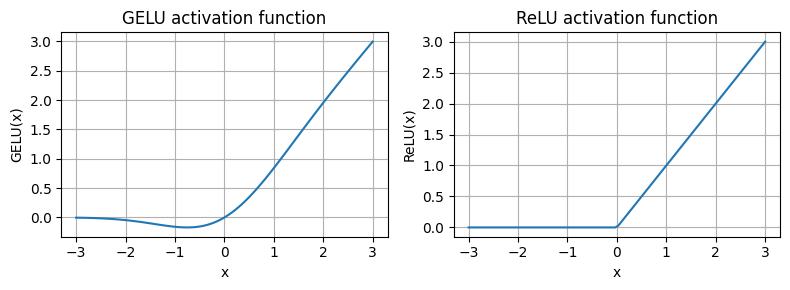

In [29]:
# Let us see how the GELU (Gaussian Error Linear Unit) stacks up against 
# # RELU (REctified Linear Unit)
from src.chapter04.GELU import GELU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
from src.chapter04.SimpleFeedForward import SimpleFeedForward

# As we can see the smoothness of the GELU can lead to better optimization properties during training
# as it allows more nuanced finer adjustments to models parameters. In contrast, RELU has a sharp corner
# that can make adjustments difficult for very deep networks.
#
# Next we look at implementing a feed forward network with GELU activations
# See SimpleFeedForward.py
#
sff = SimpleFeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = sff(x)
print(out.shape)

torch.Size([2, 3, 768])


In [31]:
from src.chapter04.ExampleDeepNeuralNetwork import ExampleDeepNeuralNetwork

# Next we implement Shortcut Connections
# Each layer will be initialized such that it accepts an example with three input 
# values and returns three output values.
torch.manual_seed(123)
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
# model.to(device)

# Next lets print the gradients
def print_gradients(nnmodel, input_x):
    output = nnmodel(input_x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    for name, param in nnmodel.named_parameters():
        # print(name, " = ", param)
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

#
# Now Lets use this function to print the gradients calculated by loss.backward()
print_gradients(model_without_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [32]:
# As you can see above gradients become tiny aka Vanishing from Layer4 to Layer1
# Let’s now instantiate a model with skip connections and see how it compares:
torch.manual_seed(123)
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
# model.to(device)
print_gradients(model_with_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [33]:
# Note here the gradient doesn't approach a vanishingly small value during backprop.
# In conclusion, shortcut connections are important for overcoming the limitations posed 
# by the vanishing gradient problem in deep neural networks.

#### Next, we’ll connect all the previously covered concepts (layer normalization, GELU activations, feed forward module, and shortcut connections) in a transformer  block, which is the final building block we need to code the GPT architecture.

![image](../data/transformer_wiring.png)

In [34]:
# See TransformerBlock.py for the basic sequence and feedforward details
from src.chapter04.TransformerBlock import TransformerBlock

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
tr_block = TransformerBlock(GPT_CONFIG_124M)
out = tr_block(x)
#
print("Input Shape:  ", x.shape)
print("Output Shape: ", out.shape)


Input Shape:   torch.Size([2, 4, 768])
Output Shape:  torch.Size([2, 4, 768])


In [35]:
from src.chapter04.GPTModel import GPTModel 

# Let us wire up the actual GPT Model we wrote now

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
print("Input batch: ", batch)
out = model(batch)
print("Output shape: ", out.shape)
# print("Out: \n", out)


Input batch:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]], device='mps:0')
Output shape:  torch.Size([2, 4, 50257])


In [36]:
# Note above the output tensor has the shape [2, 4, 50257], since we passed in two input texts (the two sentences) 
# with four tokens each. The last dimension, 50257, corresponds to the vocabulary size of the tokenizer.
#
# To capture the total number of Parameters for a model use numel parameter value
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [37]:
# Weight Tying: The model reuses weights from the token embedding layer in its output layer
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)
# As we can see both shapes are same

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [38]:
# The token embedding and output layers are very large due to the 50,257 rows in the tokenizer’s vocabulary. 
# If we remove the output layer parameter count from the total GPT-2 model count :
total_params_gptmodel = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Total number of trainable parameters considering weight tying: "
      f"{total_params_gptmodel:,}")

# Memory Requirement
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB


# Generating text 
#### We will now write code to generate text from the predicted tensors by the GPTModel


In [39]:
def generate_text_simple(input_model, tokenids, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        token_cond = tokenids[:, -context_size:]
        with torch.no_grad():
            logits = input_model(token_cond)

        logits = logits[:, -1, :]
        probabs = torch.softmax(logits, dim=-1)
        next_token = torch.argmax(probabs, dim=-1, keepdim=True)
        tokenids = torch.cat((tokenids, next_token), dim=1)

        return tokenids
#    
#  Try it with a sample sentence  
#    
start_context = "Hello, I am "
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
#
encoded_tensor = torch.tensor(encoded).to(device).unsqueeze(0)
print("encoded_tensor.shape: ", encoded_tensor.shape)
#
model.eval()
out = generate_text_simple(
    input_model=model,
    tokenids=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

encoded:  [15496, 11, 314, 716, 220]
encoded_tensor.shape:  torch.Size([1, 5])
Output: tensor([[15496,    11,   314,   716,   220, 24464]], device='mps:0')
Output length: 6


In [40]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am opia


# Chapter 5: Pretraining on unlabeled data
#### Using GPT to generate text

In [41]:
GPT_CONFIG_124M_2 = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,
    "qkv_bias": False,
    "model_name": "GPTModel",
    "lr": 5e-4,
    "weight_decay": 0.1
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(torch.device("mps"))
model.eval()

# Utility function
def text_to_token_ids(txt, tokenizr):
    encoded_txt = tokenizr.encode(txt, allowed_special={'<|endoftext|>'})
    encoded_tnsr = torch.tensor(encoded_txt).to(device).unsqueeze(0)
    return encoded_tnsr

# Utility function
def token_ids_to_text(tokenids, tokenizr):
    flat = tokenids.squeeze(0)
    return tokenizr.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    input_model=model,
    tokenids=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you Ae


In [42]:
# How to calculate loss and relatively randomize next word prediction
#
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]]).to(device)   #  "I really like"]
#
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]]).to(device)  #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(f"probas: {probas.shape}")

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f"Token IDs: {token_ids}")

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.set_printoptions(sci_mode=True)
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Softmax scores for Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Softmax scores for Text 2: ", target_probas_2)

# The goal of training an LLM is to maximize the likelihood of the correct token, 
# which involves increasing its probability relative to other tokens. 

# Loss of probabilities for the two batches are
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("Log probabilities for both batches are: \n", log_probas)

# Next, we combine the log probabilities into a single score by computing 
# the average
avg_log_probas = torch.mean(log_probas)
print(f"Average log probability: {avg_log_probas}")

# However, in deep learning, the common practice isn’t to push the average log probability 
# up to 0 but rather to bring the negative average log probability down to 0. The negative 
# average log probability is simply the average log probability multiplied by –1
neg_avg_log_probabs = avg_log_probas * -1
print(f"Negative of average log probability: {neg_avg_log_probabs}")

# In deep learning, the term for turning this negative value, –10.7940, into 10.7940, 
# is known as the cross entropy loss.


probas: torch.Size([2, 3, 50257])
Token IDs: tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]], device='mps:0')
Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday
Softmax scores for Text 1: tensor([2.3466e-05, 2.0531e-05, 1.1733e-05], device='mps:0')
Softmax scores for Text 2:  tensor([4.2794e-05, 1.6248e-05, 1.1586e-05], device='mps:0')
Log probabilities for both batches are: 
 tensor([-1.0660e+01, -1.0794e+01, -1.1353e+01, -1.0059e+01, -1.1028e+01, -1.1366e+01],
       device='mps:0')
Average log probability: -10.876513481140137
Negative of average log probability: 10.876513481140137


#### NOTE: Our goal during training is to get the average log probability as close to 0 as possible by updating the model’s weights

In [43]:
print("Logits shape:", logits.shape) # batch size, num of tokens, vocab size
print("Targets shape:", targets.shape) # batch size, num of tokens

# For the cross_entropy loss function in PyTorch, we want to flatten these 
# tensors by combining them over the batch dimension:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

# Now we can call CE from torch to calculate the loss
celoss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"Cross Entropy loss: {celoss}")

# Perplexity measures how well the probability distribution predicted by the model 
# matches the actual distribution of the words in the dataset. Similar to the loss, 
# a lower perplexity means the model predictions are closer to the actual distribution.
perplexity = torch.exp(celoss)
print(f"Perplexity: {perplexity}")


Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Cross Entropy loss: 10.876513481140137
Perplexity: 52918.7734375


In [44]:
from src.chapter02.Dataloader import Dataloader

# To implement the data splitting and loading, we first define a train_ratio 
# to use 90% of the data for training and the remaining 10% as validation data 
# for model evaluation during training
train_ratio = 0.9
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]


torch.manual_seed(123)

train_loader = Dataloader(
    batch_size=2,
    max_length=GPT_CONFIG_124M_2["context_length"],
    stride=GPT_CONFIG_124M_2["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
).create_dataloader_v1(train_data)
# print("Created train_loader...")
val_loader = Dataloader(
    batch_size=2,
    max_length=GPT_CONFIG_124M_2["context_length"],
    stride=GPT_CONFIG_124M_2["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
).create_dataloader_v1(val_data)
# print("Created val_loader...")

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    
# Calculate batch loss    
def calculate_batch_loss(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

# Calculate loss across batches
def calculate_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calculate_batch_loss(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

model.to(device)
with torch.no_grad():
    train_loss = calculate_loss_loader(train_loader, model, device)
    val_loss = calculate_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

# Model Evaluation
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calculate_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

# A convenience function that we use to track whether the model improves during the training. 
# The generate_and_print_sample() function takes a text snippet (start_context) as input, 
# converts it into token IDs, and feeds it to the LLM to generate a text sample 
# using the generate_text_simple function
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            input_model=model, 
            tokenids=encoded,
            max_new_tokens=50, 
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()


# 
# Now we implement the model training flow 
#
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calculate_batch_loss(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen




Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
Training loss: 10.988501760694716
Validation loss: 10.990342140197754


In [45]:


torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M_2)
model.to(device)
optimizer = torch.optim.AdamW(
     model.parameters(),
    lr=0.0004, 
    weight_decay=0.1
)
num_epochs = 8
# 
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.847, Val loss 10.813
Ep 1 (Step 000005): Train loss 10.536, Val loss 10.618
Every effort moves youucked
Ep 2 (Step 000010): Train loss 9.487, Val loss 9.629
Ep 2 (Step 000015): Train loss 8.373, Val loss 8.572
Every effort moves you--
Ep 3 (Step 000020): Train loss 7.176, Val loss 7.471
Ep 3 (Step 000025): Train loss 6.333, Val loss 6.823
Every effort moves you--
Ep 4 (Step 000030): Train loss 6.116, Val loss 6.669
Ep 4 (Step 000035): Train loss 6.099, Val loss 6.714
Every effort moves you,
Ep 5 (Step 000040): Train loss 6.021, Val loss 6.737
Every effort moves you 
Ep 6 (Step 000045): Train loss 6.075, Val loss 6.770
Ep 6 (Step 000050): Train loss 6.045, Val loss 6.790
Every effort moves you,
Ep 7 (Step 000055): Train loss 6.064, Val loss 6.814
Ep 7 (Step 000060): Train loss 6.020, Val loss 6.826
Every effort moves you,
Ep 8 (Step 000065): Train loss 5.969, Val loss 6.817
Ep 8 (Step 000070): Train loss 6.031, Val loss 6.829
Every effort moves you,


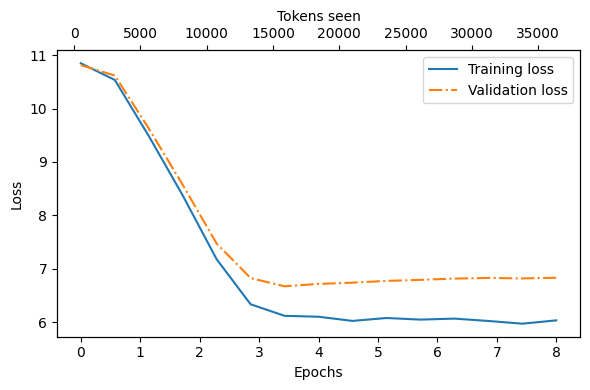

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [47]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    input_model=model,
    tokenids=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

# Now lets look at Temperature Scaling
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}
# Assume the model generates the following logits 
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
).to(device)

# We now generally do an argmax of the probabilities 
probas = torch.softmax(next_token_logits, dim=0).to(device)
next_token_id = torch.argmax(probas).item()
print(f"Next token (argmax): {inverse_vocab[next_token_id]}")
#
# But we can try replacing argmax with multinomial and get a sampling
#
torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(f"Next token (multinomial): {inverse_vocab[next_token_id]}")
# 
# Let's see if multinomial can produce any other probabilites
def print_sampled_tokens(probabs):
    torch.manual_seed(123)
    # Multinomial Sampling of probabilities instead of max
    samples = [torch.multinomial(probabs, num_samples=1).item() for _ in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(samples).to(device))
    for cnt, freq in enumerate(sampled_ids):
        print(f"Sampled Freq. {freq} : {inverse_vocab[cnt]}")

print_sampled_tokens(probas)

Output text:
 Every effort moves you,
Next token (argmax): forward
Next token (multinomial): forward
Sampled Freq. 72 : closer
Sampled Freq. 2 : every
Sampled Freq. 0 : effort
Sampled Freq. 575 : forward
Sampled Freq. 2 : inches
Sampled Freq. 0 : moves
Sampled Freq. 0 : pizza
Sampled Freq. 343 : toward
Sampled Freq. 6 : you


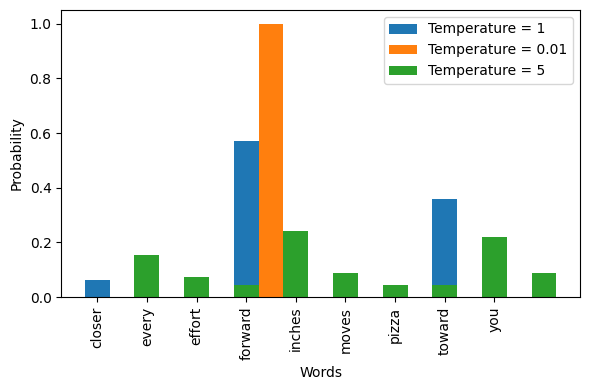

In [48]:
# We can further control the distribution by a technique called temperature scaling
# meaning dividing the logits with a >0 number
def softmax_with_temperature(logits, temperature, dim):
    scaled_logits = logits / temperature
    scaled_probs =  torch.softmax(scaled_logits, dim=dim)
    return scaled_probs

# Let's check that out
temperatures = [1, .01, 5]
next_token_logits = Tensor.cpu(next_token_logits)
scaled_probas = [softmax_with_temperature(next_token_logits, float(T), 0) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.5
fig, ax = plt.subplots(figsize=(6, 4))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, 
                   scaled_probas[i], 
                   bar_width, 
                   label=f'Temperature = {T}'
    )
ax.set_ylabel('Probability')
ax.set_xlabel('Words')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()



## Top K sampling

In [49]:
# Previously we implemented a probabilistic sampling approach coupled with 
# temperature scaling to increase the diversity of the outputs.  This method 
# allows for the exploring of less likely but potentially more interesting and 
# creative paths in the generation process.
#
# Top-k sampling, when combined with probabilistic sampling and temperature 
# scaling, can improve the text generation results.
#
# Here we can restrict the sampled tokens to the top-k most likely tokens 
# and exclude all other tokens from the selection process by masking their 
# probability scores

top_k = 3
torch.set_printoptions(sci_mode=False)
# 
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top Logits: ", top_logits)
print("Top Positions: ", top_pos)
print(f"Next token logits: {next_token_logits}")

# Pytorch WHERE function to set the logit values of tokens that are below the lowest 
# logit value within our top-three selection to negative infinity (-inf)
#
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print("New Logits: ", new_logits)

# Now apply the softmax
topk_probas = torch.softmax(new_logits, dim=0)
print(f"top k probabilities: {topk_probas}")
# 
# We can now apply the temperature scaling and multinomial function for probabilistic 
# sampling to select the next token among these three non-zero probability scores to 
# generate the next token with more diversity.

def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    print("Entering generate()..")
    # print(idx.shape)
    for i in range(max_new_tokens):
        # print(f"idx: [{i}]: {idx}")
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        #     
        logits = logits[:, -1, :] # ([1, 50257])
        # print(logits.shape)
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1] # Less than the lowest value of top k
            # Now mark the minvals with -inf, so softmax becomes 0
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            probs = softmax_with_temperature(logits, temperature, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
        else: 
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            
        if idx_next == eos_id:
            break
        
        #     logits = logits / temperature
        #     probs = torch.softmax(logits, dim=-1)
        #     idx_next = torch.multinomial(probs, num_samples=1)
        # Next word
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M_2["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))



Top Logits:  tensor([6.7500, 6.2800, 4.5100])
Top Positions:  tensor([3, 7, 0])
Next token logits: tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])
New Logits:  tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
top k probabilities: tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
Entering generate()..
Output text:
 Every effort moves you in the to the't was, had his a my
 of it a


In [50]:
# torch.save(model.state_dict(), f"/Users/amlanchatterjee/Documents/ws/python/PycharmProjects/SimpleLLMProject/models/{GPT_CONFIG_124M_2['model_name']}.pth")
MODEL_PATH = f"/Users/amlanchatterjee/Documents/ws/python/PycharmProjects/SimpleLLMProject/models/{GPT_CONFIG_124M_2['model_name']}.pth"
# 
torch.save(
    {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    MODEL_PATH
)
# 

In [51]:
# Load the model back
checkpoint = torch.load(MODEL_PATH, map_location=device)
# 
model = GPTModel(GPT_CONFIG_124M_2)
model.load_state_dict(checkpoint["model_state_dict"])
# 
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr=GPT_CONFIG_124M_2["lr"], 
                             weight_decay=GPT_CONFIG_124M_2["weight_decay"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# 
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (sff): SimpleFeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
   